### Conservation of transcription factor binding sites overlapping variants associated with disease (OMIM)

This notebook aims to analyse the conservation of transcription factor binding sites overlapping variants associated with disease (OMIM).

We will intersect JASPAR with OMIM using [bedtools intersect](https://bedtools.readthedocs.io/en/latest/content/tools/intersect.html).

We will use the OMIM regions <=100 as we are more interested in SNPs and indels.

To make this command as a one-liner, we will combine process substitution and pipes.

```
bedtools intersect \
-a jaspar2022_unique_sorted_distinct.bed \
-b <(cut -f2-4,19 ../ref/omim/omim.txt | awk '(NR>1) && ($3-$2)<=100' | sed 's/\.0//g') -wao \
| awk '$NF>0' \
> ../../doc/omim/jaspar2022_unique_sorted_distinct_omim_len100.wao
```

We will compare the conservation of the OMIM overlapping binding sites and 20,000 randomly selected binding sites.

We will download phyloP241way bigwig file from Zoonomia.

```
wget https://cgl.gi.ucsc.edu/data/cactus/241-mammalian-2020v2-hub/Homo_sapiens/241-mammalian-2020v2.bigWig -O ref

We will convert bigwig to bedgraph for bedtools intersect later on.

```
bigWigToBedGraph ref/241-mammalian-2020v2.bigWig ref/241-mammalian-2020v2.bg

To speed up the analysis, we will split phyloP bedgraph file by chromosomes (the first field) and use GNU parallel.

```
mkdir ref/phylop241way_zoonomia
cd ref/phylop241way_zoonomia
awk '{print>$1}' ../241-mammalian-2020v2.bg

We will install GNU parallel and run 8 jobs in parallel.

```
conda install -c conda-forge parallel

ls \
| parallel -j 8 \
"bedtools intersect -a ../../doc/omim/jaspar2022_unique_sorted_distinct_omim_len100.wao -b {} -wao > {}.wao"

We will get at least one nt intersect for the files.

```
for i in *.wao; do awk '$NF>0' $i > ${i%.*}.txt; done

We will go through the same process for phyloP100way.

```
# download phyloP100way bigwig from UCSC
cd ../..
wget http://hgdownload.cse.ucsc.edu/goldenpath/hg38/phyloP100way/hg38.phyloP100way.bw -O ref

# convert to bigwig to bedgraph for bedtools intersect
bigWigToBedGraph ref/hg38.phyloP100way.bw ref/hg38.phyloP100way.bg

# split the phyloP bedgraph file
mkdir ref/phylop100way
cd ref/phylop100way
awk '{print>$1}' ../hg38.phyloP100way.bg

# run parallel jobs
ls \
| parallel -j 8 \
"bedtools intersect -a ../../doc/omim/jaspar2022_unique_sorted_distinct_omim_len100.wao -b {} -wao > {}.wao"

for i in *.wao; do awk '$NF>0' $i > ${i%.*}.txt; done
```

We will read the text files for phyloP241 intersecting with JASPAR.

In [88]:
import pandas as pd
import numpy as np


phylop241 = []
for i in glob('../ref/phylop241way_zoonomia/*_241.txt'):
    try:
        phylop241.append(pd.read_csv(i, header=None, sep='\t'))
    except:
        print(os.path.basename(i))

chr21_241.txt
chrY_241.txt


We will concatenate the list of dataframe to create a single dataframe.

We can use unique() to return unique chromosomes.

In [89]:
phylop241 = pd.concat(phylop241)
phylop241[0].unique()

array(['chr15', 'chr22', 'chr5', 'chr10', 'chr14', 'chr1', 'chr11',
       'chr4', 'chr12', 'chr19', 'chrX', 'chr7', 'chr20', 'chr17', 'chr9',
       'chr2', 'chr6', 'chr18', 'chr13', 'chr3', 'chr8', 'chr16'],
      dtype=object)

In [90]:
phylop241.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209849,79209850,3.209,1
1,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209850,79209851,6.375,1
2,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209851,79209852,5.798,1
3,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209852,79209853,8.000,1
4,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209853,79209854,5.775,1


In [91]:
phylop241.shape

(2692, 17)

We will get the median phyloP scores per position.

In [93]:
phylop241_omim_median = pd.DataFrame(phylop241.groupby([8,9,10])[15].apply(np.median)).reset_index()

In [94]:
phylop241_omim_median

,8,9,10,15
0,1167863,1167952,False,4.4770
1,1713903,1713987,False,6.6480
2,1816159,1816238,False,-1.2935
3,2049908,2050008,False,5.4725
4,2652777,2652842,False,2.3590
...,...,...,...,...
91,181221979,181222051,False,1.3710
92,184241405,184241489,False,3.3600
93,195699401,195699497,False,0.3250
94,220118157,220118241,False,-0.5150


We will merge the median phyloP scores back with the original dataframe.

Column 5 has comma separated transcription factors. We will split them by comma to create lists of transcription factors.

In [95]:
phylop241_omim_median = pd.merge(phylop241, phylop241_omim_median, on=[8,9,10])
phylop241_omim_median['TFs'] = phylop241_omim_median[5].str.split(',')

In [96]:
phylop241_omim_median

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15_x,16,15_y,TFs
0,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209849,79209850,3.209,1,3.003,"[GATA2, GATA4, TCF12]"
1,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209850,79209851,6.375,1,3.003,"[GATA2, GATA4, TCF12]"
2,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209851,79209852,5.798,1,3.003,"[GATA2, GATA4, TCF12]"
3,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209852,79209853,8.000,1,3.003,"[GATA2, GATA4, TCF12]"
4,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209853,79209854,5.775,1,3.003,"[GATA2, GATA4, TCF12]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,chr16,56858590,56858604,+,hg38_chr16:56858591-56858604(+),CEBPA,CEBPA_GSE29195_U937_BIO_hg18_processed,chr16,56858518,56858601,False,11,chr16,56858599,56858600,7.032,1,6.336,[CEBPA]
2688,chr16,56858590,56858604,+,hg38_chr16:56858591-56858604(+),CEBPA,CEBPA_GSE29195_U937_BIO_hg18_processed,chr16,56858518,56858601,False,11,chr16,56858600,56858601,0.604,1,6.336,[CEBPA]
2689,chr16,56858590,56858604,+,hg38_chr16:56858591-56858604(+),CEBPA,CEBPA_GSE29195_U937_BIO_hg18_processed,chr16,56858518,56858601,False,11,chr16,56858601,56858602,6.332,1,6.336,[CEBPA]
2690,chr16,56858590,56858604,+,hg38_chr16:56858591-56858604(+),CEBPA,CEBPA_GSE29195_U937_BIO_hg18_processed,chr16,56858518,56858601,False,11,chr16,56858602,56858603,6.306,1,6.336,[CEBPA]


In [99]:
jaspar_omim_phylop241_median = phylop241_omim_median.groupby([8,9,10,'15_y'])['TFs'].agg(list).reset_index()
jaspar_omim_phylop241_median['Number of binding sites'] = jaspar_omim_phylop241_median.TFs.apply(len)
jaspar_omim_phylop241_median['Unique TFs'] = jaspar_omim_phylop241_median.TFs.apply(set)
jaspar_omim_phylop241_median['Number of unique TFs'] = jaspar_omim_phylop241_median['Unique TFs'].apply(len)

In [295]:
jaspar_omim_phylop241_median

,8,9,10,15_y,TFs,Number of binding sites,Unique TFs,Number of unique TFs
0,1167863,1167952,False,4.4770,"[[TCF7], [TCF7], [TCF7], [TCF7], [TCF7], [TCF7...",11,[TCF7],1
1,1713903,1713987,False,6.6480,"[[SCRT2], [SCRT2], [SCRT2], [SCRT2], [SCRT2], ...",24,"[SCRT2, BACH1]",2
2,1816159,1816238,False,-1.2935,"[[TFAP2C], [TFAP2C], [TFAP2C], [TFAP2C], [TFAP...",14,[TFAP2C],1
3,2049908,2050008,False,5.4725,"[[EGR1, KLF9, TCF12, TCF3], [EGR1, KLF9, TCF12...",121,"[KLF9, RFX3, RFX1, TCF12, EGR1, TCF3, SOX2]",7
4,2652777,2652842,False,2.3590,"[[PAX5], [PAX5], [PAX5], [PAX5], [PAX5], [PAX5...",62,"[TCF4, PAX5, SNAI2]",3
...,...,...,...,...,...,...,...,...
91,181221979,181222051,False,1.3710,"[[MAFK], [MAFK], [MAFK], [MAFK], [MAFK], [MAFK...",22,"[YY2, MAFK]",2
92,184241405,184241489,False,3.3600,"[[KLF4], [KLF4], [KLF4], [KLF4], [KLF4], [KLF4...",23,[KLF4],1
93,195699401,195699497,False,0.3250,"[[HOXB13], [HOXB13], [HOXB13], [HOXB13], [HOXB...",6,[HOXB13],1
94,220118157,220118241,False,-0.5150,"[[FOXA2], [FOXA2], [FOXA2], [FOXA2], [FOXA2], ...",23,"[FOXA1, FOXA2]",2


In [100]:
jaspar_omim_phylop241_median.shape

(96, 8)

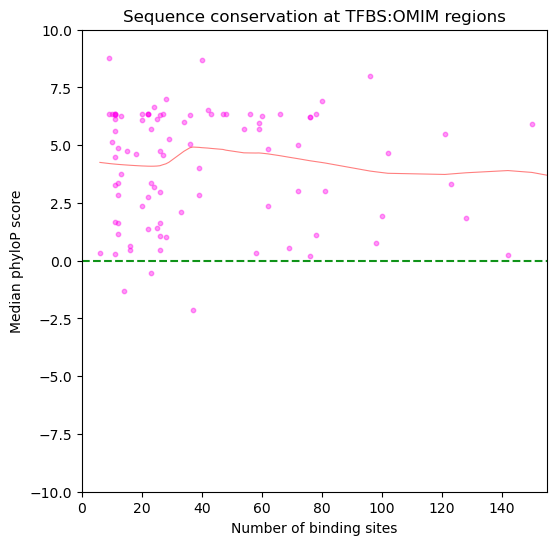

In [286]:
plt.figure(figsize=(6,6))
plt.ylim(-10, 10)
plt.xlim(0, 155)
sns.regplot(data=jaspar_omim_phylop241_median, x='Number of binding sites', y='15_y', lowess=True, scatter_kws=dict(alpha=0.4, s=10, color='#ff03ecff'), line_kws=dict(alpha=0.5, color='red', linewidth=0.8))
plt.axhline(0, linestyle=('--'), dash_joinstyle ='miter', color='#109319ff')
plt.title('Sequence conservation at TFBS:OMIM regions')
plt.ylabel('Median phyloP score')
plt.show()

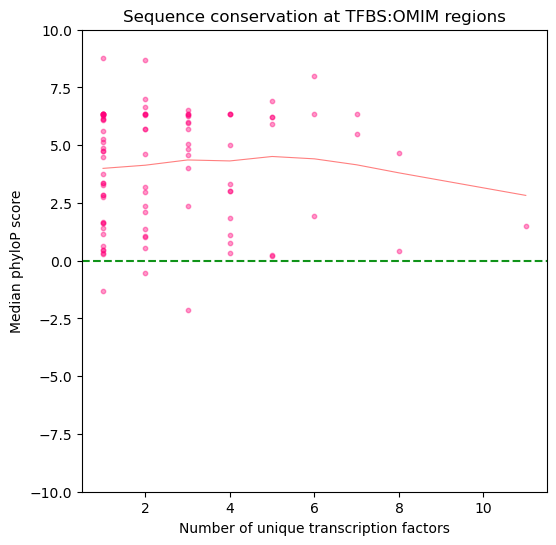

In [294]:
plt.figure(figsize=(6,6))
plt.ylim(-10, 10)
sns.regplot(data=jaspar_omim_phylop241_median, x='Number of unique TFs', y='15_y', lowess=True, scatter_kws=dict(alpha=0.4, s=10, color='#ff007aff'), line_kws=dict(alpha=0.5, color='red', linewidth=0.8))
plt.axhline(0, linestyle=('--'), dash_joinstyle ='miter', color='#109319ff')
plt.title("Sequence conservation at TFBS:OMIM regions")
plt.ylabel('Median phyloP score')
plt.xlabel('Number of unique transcription factors')
plt.show()

The clinically associated variants in OMIM have disease and non-disease status.

We will get these subsets and plot their phyloP scores.

In [211]:
p241om_F =phylop241_omim_median[phylop241_omim_median[10] == False].copy()
p241om_F

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15_x,16,15_y,TFs
34,chr22,20033180,20033193,-,hg38_chr22:20033181-20033193(-),EBF3,CistromeDB_76849,chr22,20033139,20033220,False,13,chr22,20033180,20033181,5.467,1,6.130,[EBF3]
35,chr22,20033180,20033193,-,hg38_chr22:20033181-20033193(-),EBF3,CistromeDB_76849,chr22,20033139,20033220,False,13,chr22,20033181,20033182,3.429,1,6.130,[EBF3]
36,chr22,20033180,20033193,-,hg38_chr22:20033181-20033193(-),EBF3,CistromeDB_76849,chr22,20033139,20033220,False,13,chr22,20033182,20033183,6.218,1,6.130,[EBF3]
37,chr22,20033180,20033193,-,hg38_chr22:20033181-20033193(-),EBF3,CistromeDB_76849,chr22,20033139,20033220,False,13,chr22,20033183,20033184,4.789,1,6.130,[EBF3]
38,chr22,20033180,20033193,-,hg38_chr22:20033181-20033193(-),EBF3,CistromeDB_76849,chr22,20033139,20033220,False,13,chr22,20033184,20033185,6.130,1,6.130,[EBF3]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2687,chr16,56858590,56858604,+,hg38_chr16:56858591-56858604(+),CEBPA,CEBPA_GSE29195_U937_BIO_hg18_processed,chr16,56858518,56858601,False,11,chr16,56858599,56858600,7.032,1,6.336,[CEBPA]
2688,chr16,56858590,56858604,+,hg38_chr16:56858591-56858604(+),CEBPA,CEBPA_GSE29195_U937_BIO_hg18_processed,chr16,56858518,56858601,False,11,chr16,56858600,56858601,0.604,1,6.336,[CEBPA]
2689,chr16,56858590,56858604,+,hg38_chr16:56858591-56858604(+),CEBPA,CEBPA_GSE29195_U937_BIO_hg18_processed,chr16,56858518,56858601,False,11,chr16,56858601,56858602,6.332,1,6.336,[CEBPA]
2690,chr16,56858590,56858604,+,hg38_chr16:56858591-56858604(+),CEBPA,CEBPA_GSE29195_U937_BIO_hg18_processed,chr16,56858518,56858601,False,11,chr16,56858602,56858603,6.306,1,6.336,[CEBPA]


In [213]:
p241om_T =phylop241_omim_median[phylop241_omim_median[10] == True].copy()
p241om_T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15_x,16,15_y,TFs
0,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209849,79209850,3.209,1,3.003,"[GATA2, GATA4, TCF12]"
1,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209850,79209851,6.375,1,3.003,"[GATA2, GATA4, TCF12]"
2,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209851,79209852,5.798,1,3.003,"[GATA2, GATA4, TCF12]"
3,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209852,79209853,8.000,1,3.003,"[GATA2, GATA4, TCF12]"
4,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209853,79209854,5.775,1,3.003,"[GATA2, GATA4, TCF12]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,chr9,127785988,127786016,-,"hg38_chr9:127785989-127786004(-),hg38_chr9:127...","EGR1,SPIB","GSE56857.spib.ocily3_shctr,wgEncodeAwgTfbsHaib...",chr9,127785918,127786007,True,19,chr9,127786011,127786012,3.505,1,5.705,"[EGR1, SPIB]"
1897,chr9,127785988,127786016,-,"hg38_chr9:127785989-127786004(-),hg38_chr9:127...","EGR1,SPIB","GSE56857.spib.ocily3_shctr,wgEncodeAwgTfbsHaib...",chr9,127785918,127786007,True,19,chr9,127786012,127786013,0.321,1,5.705,"[EGR1, SPIB]"
1898,chr9,127785988,127786016,-,"hg38_chr9:127785989-127786004(-),hg38_chr9:127...","EGR1,SPIB","GSE56857.spib.ocily3_shctr,wgEncodeAwgTfbsHaib...",chr9,127785918,127786007,True,19,chr9,127786013,127786014,4.300,1,5.705,"[EGR1, SPIB]"
1899,chr9,127785988,127786016,-,"hg38_chr9:127785989-127786004(-),hg38_chr9:127...","EGR1,SPIB","GSE56857.spib.ocily3_shctr,wgEncodeAwgTfbsHaib...",chr9,127785918,127786007,True,19,chr9,127786014,127786015,8.019,1,5.705,"[EGR1, SPIB]"


In [217]:
jop241mF = p241om_F.groupby([8,9,10,'15_y'])['TFs'].agg(list).reset_index()
jop241mF['Number of binding sites'] = jop241mF.TFs.apply(len)
jop241mF['Unique TFs'] = jop241mF.TFs.apply(set)
jop241mF['Number of unique TFs'] = jop241mF['Unique TFs'].apply(len)

In [229]:
jop241mF

,8,9,10,15_y,TFs,Number of binding sites,Unique TFs,Number of unique TFs
0,1167863,1167952,False,4.4770,"[[TCF7], [TCF7], [TCF7], [TCF7], [TCF7], [TCF7...",11,[TCF7],1
1,1713903,1713987,False,6.6480,"[[SCRT2], [SCRT2], [SCRT2], [SCRT2], [SCRT2], ...",24,"[SCRT2, BACH1]",2
2,1816159,1816238,False,-1.2935,"[[TFAP2C], [TFAP2C], [TFAP2C], [TFAP2C], [TFAP...",14,[TFAP2C],1
3,2049908,2050008,False,5.4725,"[[EGR1, KLF9, TCF12, TCF3], [EGR1, KLF9, TCF12...",121,"[KLF9, RFX3, RFX1, TCF12, EGR1, TCF3, SOX2]",7
4,2652777,2652842,False,2.3590,"[[PAX5], [PAX5], [PAX5], [PAX5], [PAX5], [PAX5...",62,"[TCF4, PAX5, SNAI2]",3
...,...,...,...,...,...,...,...,...
88,181221979,181222051,False,1.3710,"[[MAFK], [MAFK], [MAFK], [MAFK], [MAFK], [MAFK...",22,"[YY2, MAFK]",2
89,184241405,184241489,False,3.3600,"[[KLF4], [KLF4], [KLF4], [KLF4], [KLF4], [KLF4...",23,[KLF4],1
90,195699401,195699497,False,0.3250,"[[HOXB13], [HOXB13], [HOXB13], [HOXB13], [HOXB...",6,[HOXB13],1
91,220118157,220118241,False,-0.5150,"[[FOXA2], [FOXA2], [FOXA2], [FOXA2], [FOXA2], ...",23,"[FOXA1, FOXA2]",2


In [228]:
p241om_T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15_x,16,15_y,TFs
0,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209849,79209850,3.209,1,3.003,"[GATA2, GATA4, TCF12]"
1,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209850,79209851,6.375,1,3.003,"[GATA2, GATA4, TCF12]"
2,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209851,79209852,5.798,1,3.003,"[GATA2, GATA4, TCF12]"
3,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209852,79209853,8.000,1,3.003,"[GATA2, GATA4, TCF12]"
4,chr15,79209849,79209868,-,"hg38_chr15:79209850-79209860(-),hg38_chr15:792...","GATA2,GATA4,TCF12","REMAP_2020_Mmusculus,ReMap2020_GATA4,wgEncodeA...",chr15,79209788,79209871,True,19,chr15,79209853,79209854,5.775,1,3.003,"[GATA2, GATA4, TCF12]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,chr9,127785988,127786016,-,"hg38_chr9:127785989-127786004(-),hg38_chr9:127...","EGR1,SPIB","GSE56857.spib.ocily3_shctr,wgEncodeAwgTfbsHaib...",chr9,127785918,127786007,True,19,chr9,127786011,127786012,3.505,1,5.705,"[EGR1, SPIB]"
1897,chr9,127785988,127786016,-,"hg38_chr9:127785989-127786004(-),hg38_chr9:127...","EGR1,SPIB","GSE56857.spib.ocily3_shctr,wgEncodeAwgTfbsHaib...",chr9,127785918,127786007,True,19,chr9,127786012,127786013,0.321,1,5.705,"[EGR1, SPIB]"
1898,chr9,127785988,127786016,-,"hg38_chr9:127785989-127786004(-),hg38_chr9:127...","EGR1,SPIB","GSE56857.spib.ocily3_shctr,wgEncodeAwgTfbsHaib...",chr9,127785918,127786007,True,19,chr9,127786013,127786014,4.300,1,5.705,"[EGR1, SPIB]"
1899,chr9,127785988,127786016,-,"hg38_chr9:127785989-127786004(-),hg38_chr9:127...","EGR1,SPIB","GSE56857.spib.ocily3_shctr,wgEncodeAwgTfbsHaib...",chr9,127785918,127786007,True,19,chr9,127786014,127786015,8.019,1,5.705,"[EGR1, SPIB]"


In [223]:
jop241mT = p241om_T.groupby([8,9,10,'15_y'])['TFs'].agg(list).reset_index()
jop241mT['Number of binding sites'] = jop241mT.TFs.apply(len)
jop241mT['Unique TFs'] = jop241mT.TFs.apply(set)
jop241mT['Number of unique TFs'] = jop241mT['Unique TFs'].apply(len)

In [227]:
jop241mT

,8,9,10,15_y,TFs,Number of binding sites,Unique TFs,Number of unique TFs
0,45478601,45478687,True,6.313,"[[GRHL2, SCRT1], [GRHL2, SCRT1], [GRHL2, SCRT1...",26,"[SCRT1, GRHL2]",2
1,79209788,79209871,True,3.003,"[[GATA2, GATA4, TCF12], [GATA2, GATA4, TCF12],...",72,"[TCF12, PKNOX1, GATA2, GATA4]",4
2,127785918,127786007,True,5.705,"[[EBF1], [EBF1], [EBF1], [EBF1], [EBF1], [EBF1...",59,"[EGR1, SPIB, EBF1]",3


We will plot the median phyloP scores vs the number of transcription factors.

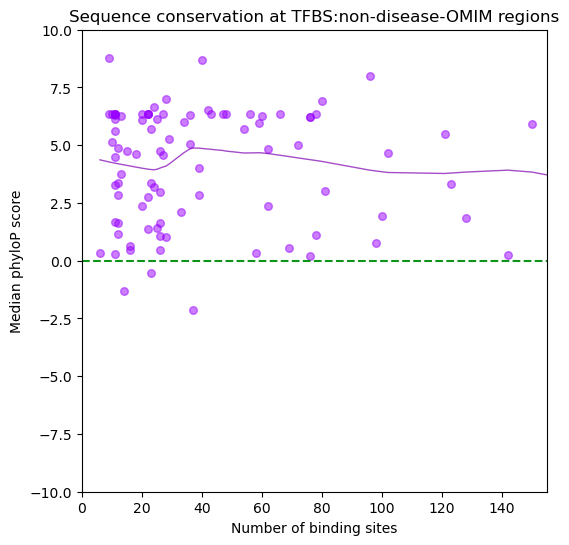

In [321]:
plt.figure(figsize=(6,6))
plt.ylim(-10, 10)
plt.xlim(0, 155)
sns.regplot(data=jop241mF, x='Number of binding sites', y='15_y', lowess=True, scatter_kws=dict(alpha=0.5, s=30, color='#9800ffff'), line_kws=dict(alpha=0.7, color='#7f00b3ff', linewidth=1))
plt.axhline(0, linestyle=('--'), dash_joinstyle ='miter', color='#109319ff')
plt.title('Sequence conservation at TFBS:non-disease-OMIM regions')
plt.ylabel('Median phyloP score')
plt.show()

In [297]:
jop241mT

,8,9,10,15_y,TFs,Number of binding sites,Unique TFs,Number of unique TFs
0,45478601,45478687,True,6.313,"[[GRHL2, SCRT1], [GRHL2, SCRT1], [GRHL2, SCRT1...",26,"[SCRT1, GRHL2]",2
1,79209788,79209871,True,3.003,"[[GATA2, GATA4, TCF12], [GATA2, GATA4, TCF12],...",72,"[TCF12, PKNOX1, GATA2, GATA4]",4
2,127785918,127786007,True,5.705,"[[EBF1], [EBF1], [EBF1], [EBF1], [EBF1], [EBF1...",59,"[EGR1, SPIB, EBF1]",3


In [298]:
871-788

83

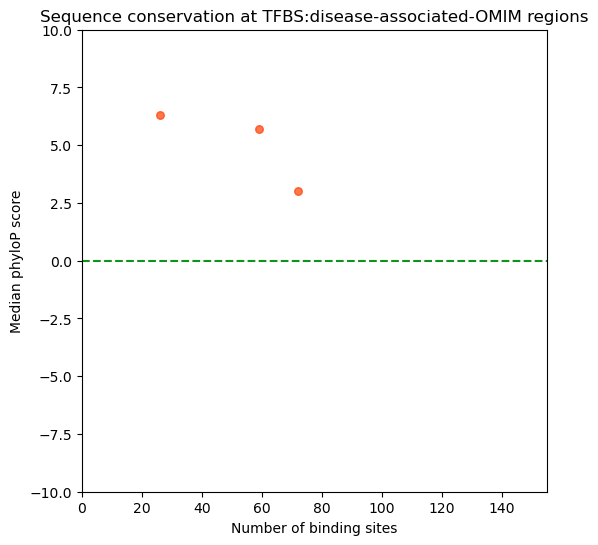

In [320]:
plt.figure(figsize=(6,6))
plt.ylim(-10, 10)
plt.xlim(0, 155)
sns.regplot(data=jop241mT, x='Number of binding sites', y='15_y', lowess=True, scatter_kws=dict(alpha=0.7, s=30, color='#ff3e00ff'), line_kws=dict(alpha=0.0001, color='grey', linewidth=1))
plt.axhline(0, linestyle=('--'), dash_joinstyle ='miter', color='#109319ff')
plt.title('Sequence conservation at TFBS:disease-associated-OMIM regions')
plt.ylabel('Median phyloP score')
plt.show()

We will plot the median phyloP scores vs the number of unique transcription factors.

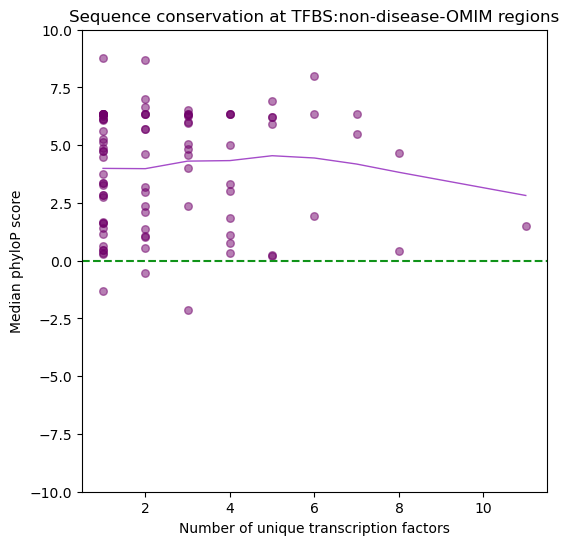

In [316]:
plt.figure(figsize=(6,6))
plt.ylim(-10, 10)
sns.regplot(data=jop241mF, x='Number of unique TFs', y='15_y', lowess=True, scatter_kws=dict(alpha=0.5, s=30, color='#70006aff'), line_kws=dict(alpha=0.7, color='#7f00b3ff', linewidth=1))
plt.axhline(0, linestyle=('--'), dash_joinstyle ='miter', color='#109319ff')
plt.xlabel('Number of unique transcription factors')
plt.title('Sequence conservation at TFBS:non-disease-OMIM regions')
plt.ylabel('Median phyloP score')
plt.show()

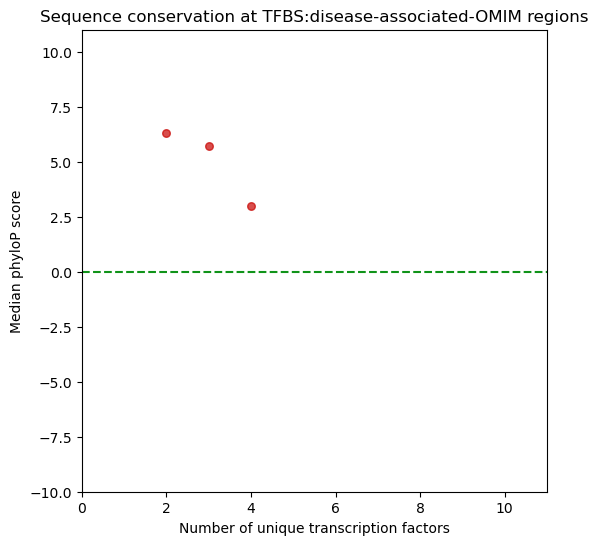

In [322]:
plt.figure(figsize=(6,6))
plt.ylim(-10, 11)
plt.xlim(0, 11)
sns.regplot(data=jop241mT, x='Number of unique TFs', y='15_y', lowess=True, scatter_kws=dict(alpha=0.7, s=30, color='#c80300ff'), line_kws=dict(alpha=0.0001, color='grey', linewidth=1))
plt.axhline(0, linestyle=('--'), dash_joinstyle ='miter', color='#109319ff')
plt.xlabel('Number of unique transcription factors')
plt.title('Sequence conservation at TFBS:disease-associated-OMIM regions')
plt.ylabel('Median phyloP score')
plt.show()

We will create a "null" for comparison.

Let's read the BED file we created in [jaspar.ipynb](https://github.com/compgenom/bioinfo_lessons/blob/main/jupyter_notebooks/jaspar.ipynb) and call it as "null". 

We will sample randomly sample 20,000 binding sites.

In [41]:
import pandas as pd

null = pd.read_csv('../ref/jaspar/jaspar2022_unique_sorted_distinct.bed', sep='\t', header=None)
null.shape

(5350878, 7)

In [296]:
null

,0,1,2,3,4,5,6
0,chr1,126159,126171,-,hg38_chr1:126160-126171(-),FOXA1,wgEncodeAwgTfbsHaibHepg2Foxa1sc6553V0416101Uni...
1,chr1,126161,126173,+,hg38_chr1:126162-126173(+),FOXA1,wgEncodeAwgTfbsHaibHepg2Foxa1sc6553V0416101Uni...
2,chr1,136714,136728,-,hg38_chr1:136715-136728(-),EGR1,wgEncodeAwgTfbsHaibK562Egr1V0416101UniPk.narro...
3,chr1,136762,136776,-,hg38_chr1:136763-136776(-),EGR1,wgEncodeAwgTfbsHaibK562Egr1V0416101UniPk.narro...
4,chr1,181415,181429,-,hg38_chr1:181416-181429(-),TFAP2C,REMAP_2020_Mmusculus
...,...,...,...,...,...,...,...
5350873,chrY,56851673,56851684,+,hg38_chrY:56851674-56851684(+),FOXA2,ReMap2020_FOXA2
5350874,chrY,56868760,56868775,+,hg38_chrY:56868761-56868775(+),MAFK,wgEncodeAwgTfbsSydhHepg2Mafkab50322IggrabUniPk...
5350875,chrY,56873745,56873757,+,hg38_chrY:56873746-56873757(+),FOXA1,wgEncodeAwgTfbsHaibHepg2Foxa1sc6553V0416101Uni...
5350876,chrY,56878594,56878618,+,hg38_chrY:56878595-56878618(+),ZNF382,CistromeDB_65138


In [160]:
null_samples = []
for i in range(100):
    null_sample = null.sample(n=200, random_state=i)
    null_sample['sample'] = i
    null_samples.append(null_sample)
    
null_samples = pd.concat(null_samples)
null_samples.to_csv('../ref/jaspar/jaspar2022_unique_sorted_distinct_null_20000.bed', sep='\t', header=None, index=None)

We will repeat the same data processing as above for phyloP241 and phyloP100way.

We will read the text files using a loop as above.

In [161]:
phylopn = []
for i in glob('../ref/phylop241way_zoonomia/*_null.txt'):
    try:
        phylopn.append(pd.read_csv(i, header=None, sep='\t'))
    except:
        print(i)

phylopn = pd.concat(phylopn)

We can use unique() to return unique chromosomes.

In [162]:
phylopn[0].unique()

array(['chr13', 'chr4', 'chr11', 'chr6', 'chrX', 'chr17', 'chr15', 'chr2',
       'chr19', 'chr8', 'chr21', 'chr3', 'chr14', 'chr1', 'chr16', 'chrY',
       'chr7', 'chr10', 'chr5', 'chr12', 'chr20', 'chr9', 'chr22',
       'chr18'], dtype=object)

In [163]:
phylopn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,chr13,109647285,109647299,-,hg38_chr13:109647286-109647299(-),ELF3,GSE64557.elf3.pdac_shctr,0,chr13,109647285,109647286,1.266,1
1,chr13,109647285,109647299,-,hg38_chr13:109647286-109647299(-),ELF3,GSE64557.elf3.pdac_shctr,0,chr13,109647286,109647287,0.977,1
2,chr13,109647285,109647299,-,hg38_chr13:109647286-109647299(-),ELF3,GSE64557.elf3.pdac_shctr,0,chr13,109647287,109647288,1.313,1
3,chr13,109647285,109647299,-,hg38_chr13:109647286-109647299(-),ELF3,GSE64557.elf3.pdac_shctr,0,chr13,109647288,109647289,3.847,1
4,chr13,109647285,109647299,-,hg38_chr13:109647286-109647299(-),ELF3,GSE64557.elf3.pdac_shctr,0,chr13,109647289,109647290,5.842,1


In [164]:
phylopn.shape

(2811495, 13)

We will get the median phyloP scores per position.

In [168]:
phylopn_median = pd.DataFrame(phylopn.groupby([8,9,10])[11].apply(np.median)).reset_index()

In [169]:
phylopn_median

,8,9,10,11
0,chr1,778709,778711,0.052
1,chr1,778711,778712,0.062
2,chr1,778712,778713,0.052
3,chr1,778713,778714,0.062
4,chr1,778714,778715,0.052
...,...,...,...,...
2743644,chrY,21452900,21452902,0.095
2743645,chrY,21452902,21452903,-1.567
2743646,chrY,21452903,21452910,0.095
2743647,chrY,21452910,21452911,0.120


We will merge the median phyloP scores back with the original dataframe.

Column 5 has comma separated transcription factors. We will split them by comma to create lists of transcription factors.

In [170]:
phylopn_median = pd.merge(phylopn, phylopn_median, on=[8,9,10])
phylopn_median['TFs'] = phylopn_median[5].str.split(',')

We will count the number of transcription factor binding sites.

In [171]:
jaspar_phylopn_median = phylopn_median.groupby([8,9,10,'11_y'])['TFs'].agg(list).reset_index()
jaspar_phylopn_median['Number of binding sites'] = jaspar_phylopn_median.TFs.apply(len)
jaspar_phylopn_median['Unique TFs'] = jaspar_phylopn_median.TFs.apply(set)
jaspar_phylopn_median['Number of unique TFs'] = jaspar_phylopn_median['Unique TFs'].apply(len)

In [172]:
jaspar_phylopn_median.shape

(2743649, 8)

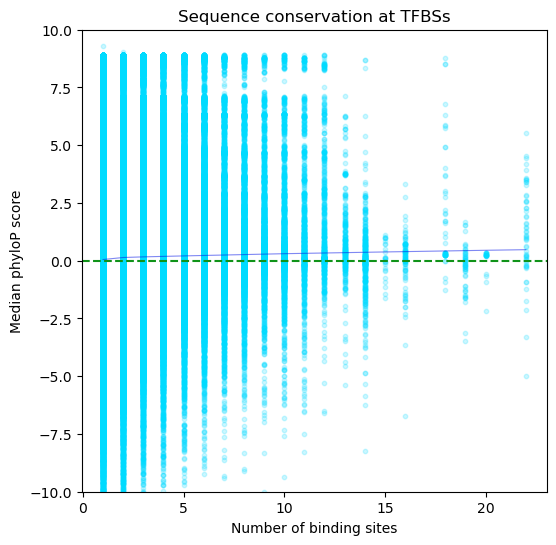

In [292]:
plt.figure(figsize=(6,6))
plt.ylim(-10, 10)
sns.regplot(data=jaspar_phylopn_median, x='Number of binding sites', y='11_y', lowess=True, scatter_kws=dict(alpha=0.2, s=10, color='#00dbffff'), line_kws=dict(alpha=0.5, color='#0012e6ff', linewidth=0.8))
plt.axhline(0, linestyle=('--'), dash_joinstyle ='miter', color='#109319ff')
plt.title("Sequence conservation at TFBSs")
plt.ylabel('Median phyloP score')
plt.xlabel('Number of binding sites')
# plt.ylim(-10, 10)
# plt.savefig('null_jaspar_phylop241_median_binding_sites.pdf')
plt.show()

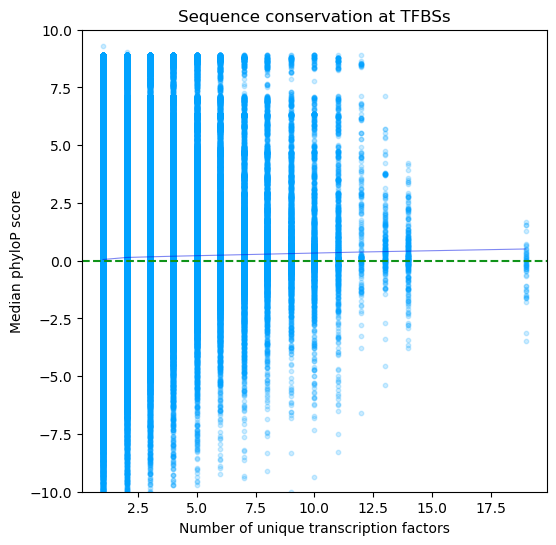

In [293]:
plt.figure(figsize=(6,6))
plt.ylim(-10, 10)
sns.regplot(data=jaspar_phylopn_median, x='Number of unique TFs', y='11_y', lowess=True, scatter_kws=dict(alpha=0.2, s=10, color='#00a2ffff'), line_kws=dict(alpha=0.5, color='#0012e6ff', linewidth=0.8))
plt.axhline(0, linestyle=('--'), dash_joinstyle ='miter', color='#109319ff')
plt.title("Sequence conservation at TFBSs")
plt.ylabel('Median phyloP score')
plt.xlabel('Number of unique transcription factors')
plt.show()